## Model Evaluation, Hyperparamter Tuning: Examples and Discussion

### Loading the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# if the Breast Cancer dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

# Explanation of the dataset
# https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
# N.B. Column 0 is an index (categorical), Column 1 is the target
# All the remaining 30 features are continuous

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.shape

(569, 32)

**Checking missing values and do imputation if needed**


**Additional Considerations on Multicollinearity**:

* Unstable Coefficients: In the presence of multicollinearity, the model struggles to determine the effect of each predictor (feature) on the outcome because highly correlated features contain redundant information. This results in large changes in the estimated coefficients, even with slight changes to the data

* While multicollinearity affects the interpretation of the logistic regression model, it does not always severely impact predictive performance. The model can still make accurate predictions despite unstable coefficients.

* If one decides to reduce multicollinearity, among the possible things to do there are (i) removing highly correlated features, (ii) dimensionality reduction, (iii) regularization

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_
le.transform(['M', 'B'])

array([1, 0])

In [6]:
# Check for NaNs and raise an assertion error if any NaN values are found
assert np.sum(np.isnan(X)) == 0, "NaN values found in X"
assert np.sum(np.isnan(y)) == 0, "NaN values found in y"

In [7]:
if np.sum(np.isnan(X)) > 0:

  # Calculate mean for each column but exclude columns you don't want to alter
  means = df.drop(columns=[0, 1]).mean()

  # Fill NaN values using the calculated means for the allowed columns only
  df.fillna(means, inplace=True)

In [8]:
num_unique_labels = df[1].nunique()
print(num_unique_labels)

unique_values = df[1].unique()
print(unique_values)

2
['M' 'B']


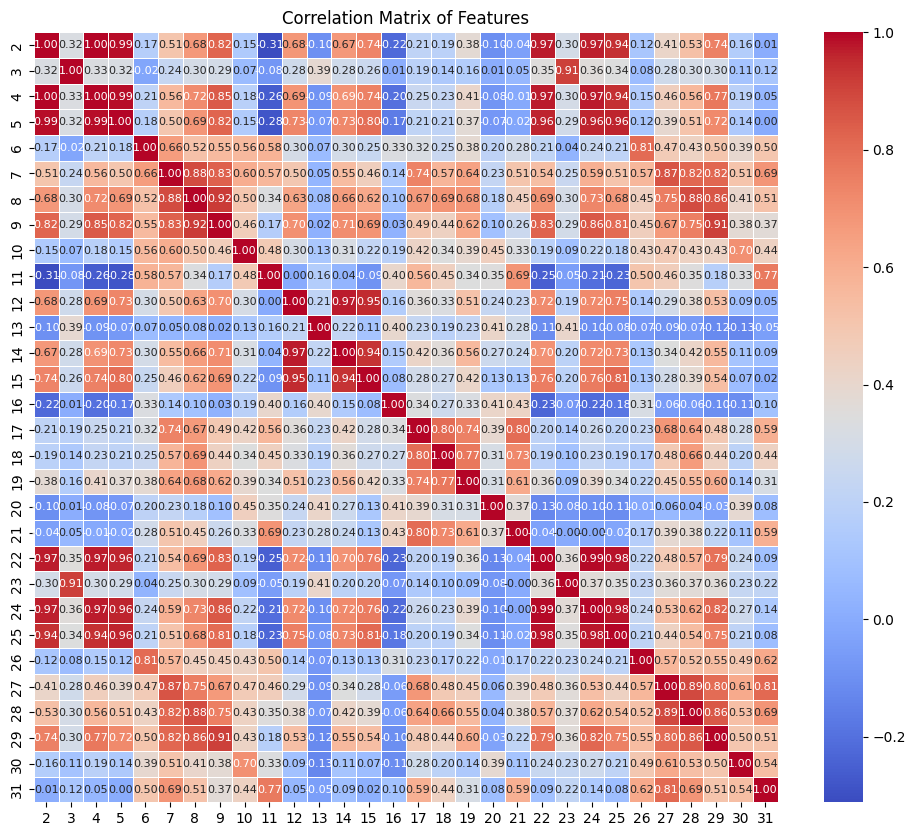

In [9]:
feature_columns = df.iloc[:, 2:]  # Exclude the first two columns if they are ID and labels

# Calculate the correlation matrix
corr_matrix = feature_columns.corr()

# Display the correlation matrix as a heatmap for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix of Features')
plt.show()

**Check class balance**

In [10]:
# benign
count_class_0 = np.sum(y==0)

# malign
count_class_1 = np.sum(y==1)

print(f"N(Benign): {count_class_0}, N(Malign): {count_class_1}")

N(Benign): 357, N(Malign): 212


**Small Digression**

Let's pretend for a moment to have an imbalanced dataset, such that 90% belong to M and only 10% belong to B. Let's define a naive classifier that classifies everything as M: what would be the accuracy of this classifier on such dataset?

**Training/Test splitting and Scaling the Features**

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assume X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)





---




### Consider the logistic regression model introuced in the past lectures, modified to L1 regression

In [40]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionGD_L1reg:
    """Gradient descent-based logistic regression classifier with L1 regularization."""

    def __init__(self, eta=0.01, n_iter=50, alpha=0.01, random_state=1, epsilon=1e-10, pred_threshold=0.5):
        self.eta = eta
        self.n_iter = n_iter
        self.alpha = alpha  # L1 regularization term
        self.random_state = random_state
        self.epsilon = epsilon  # a small value to avoid log(0)
        self.pred_threshold = pred_threshold  # threshold for classification
        self.losses_ = []
        self.val_losses_ = []  # For validation loss

    def fit(self, X_train, y_train, X_test, y_test):
        """Fit training data and track losses on both training and testing data."""
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X_train.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []
        self.val_losses_ = []

        for i in range(self.n_iter):
            # Forward pass (training)
            net_input_train = self.net_input(X_train)
            output_train = self.activation(net_input_train)
            errors_train = (y_train - output_train)

            # Gradient descent with L1 regularization for weights
            self.w_ += self.eta * (X_train.T.dot(errors_train) / X_train.shape[0] - self.alpha * np.sign(self.w_))
            self.b_ += self.eta * errors_train.mean()

            # Compute loss on training data
            loss_train = (-y_train.dot(np.log(output_train + self.epsilon)) -
                          (1 - y_train).dot(np.log(1 - output_train + self.epsilon))) / X_train.shape[0]
            loss_train += self.alpha * np.sum(np.abs(self.w_))  # L1 regularization term
            self.losses_.append(loss_train.mean())

            # Forward pass (testing/validation)
            net_input_test = self.net_input(X_test)
            output_test = self.activation(net_input_test)

            # Compute loss on test data
            loss_test = (-y_test.dot(np.log(output_test + self.epsilon)) -
                         (1 - y_test).dot(np.log(1 - output_test + self.epsilon))) / X_test.shape[0]
            loss_test += self.alpha * np.sum(np.abs(self.w_))  # L1 regularization term
            self.val_losses_.append(loss_test.mean())

        return self

    def net_input(self, X):
        """Calculate net input."""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation."""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step."""
        return np.where(self.activation(self.net_input(X)) >= self.pred_threshold, 1, 0)

    def predict_proba(self, X):
        """Return probability."""
        return self.activation(self.net_input(X))

    def plot_learning_curve(self):
        """Plot the learning curve (training vs testing loss)."""
        plt.plot(range(1, len(self.losses_) + 1), self.losses_, label='Training Loss', marker='o')
        plt.plot(range(1, len(self.val_losses_) + 1), self.val_losses_, label='Testing Loss', marker='s')
        plt.yscale('log')  # Set the y-axis to a logarithmic scale
        plt.title('Learning Curve (Loss vs. Epochs)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def score(self, X, y):
        """Compute accuracy."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

# Example usage:
# Assuming X_train, y_train are your training data and X_test, y_test are your test data
# model = LogisticRegressionGD_L1reg(eta=0.01, n_iter=100, alpha=0.01)
# model.fit(X_train, y_train, X_test, y_test)
# model.plot_learning_curve()


**Decision Region Plot Function**

In [41]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_regions_pca(X, y, classifier, resolution=0.02, pca_flag=False, pca_components=2):
    # setup marker generator and color map

    if not pca_flag:
        assert X.shape[1] == 2, "Data must be 2D if pca_flag=False."

    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    X_all = X

    # Apply PCA only if pca_flag is True
    if pca_flag:
        pca = PCA(n_components=pca_components)
        X_pca = pca.fit_transform(X)  # Fit PCA on original X and reduce to 2D

    else:
        X_pca = X  # No PCA applied, using original data

    # Create the decision surface based on PCA-transformed data (or original data if no PCA)
    x1_min, x1_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    x2_min, x2_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    # Create grid points for prediction in 2D space
    grid_points_2d = np.array([xx1.ravel(), xx2.ravel()]).T

    # If PCA was applied, inverse transform the 2D grid points back to the original feature space
    if pca_flag:
        grid_points_original_space = pca.inverse_transform(grid_points_2d)
    else:
        grid_points_original_space = grid_points_2d

    # Predict in the original feature space
    lab = classifier.predict(grid_points_original_space)
    lab = lab.reshape(xx1.shape)

    # Plot the decision surface
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot the class samples
    for idx, cl in enumerate(np.unique(y)):
        if pca_flag:
            plt.scatter(x=X_pca[y == cl, 0],
                        y=X_pca[y == cl, 1],
                        alpha=0.8,
                        c=colors[idx],
                        marker=markers[idx],
                        edgecolor='black')
        else:
            plt.scatter(x=X[y == cl, 0],
                        y=X[y == cl, 1],
                        alpha=0.8,
                        c=colors[idx],
                        marker=markers[idx],
                        edgecolor='black')

    plt.xlabel('PC1' if pca_flag else 'Feature 1')
    plt.ylabel('PC2' if pca_flag else 'Feature 2')
    plt.title('Decision regions with PCA' if pca_flag else 'Decision regions')
    plt.show()


In [59]:
lrgd_reg = LogisticRegressionGD_L1reg(eta=0.5, n_iter=2500, random_state=3, alpha=0.0)
lrgd_reg.fit(X_train_scaled, y_train, X_test_scaled, y_test)


In [60]:
y_train_pred = lrgd_reg.predict(X_train_scaled)
y_test_pred = lrgd_reg.predict(X_test_scaled)

accuracy_train = np.sum(y_train_pred == y_train) / len(y_train)
print(f"Train Accuracy: {accuracy_train * 100:.2f}%")

accuracy_test = np.sum(y_test_pred == y_test) / len(y_test)
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

# analogously
print(f"Check score: {lrgd_reg.score(X_test_scaled,y_test):.4f}")

Train Accuracy: 99.12%
Test Accuracy: 98.25%
Check score: 0.9825


**Plotting decision region in dimensionally reduced space**

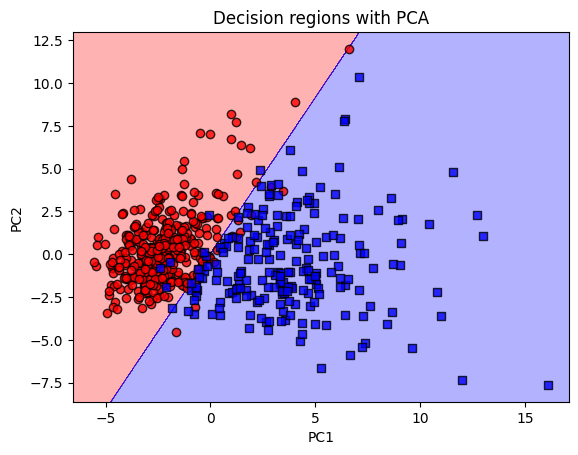

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_combined = np.vstack((X_train_scaled, X_test_scaled))  # Combine training and test data
y_combined = np.hstack((y_train, y_test))  # Combine the labels

X_combined = np.vstack((X_train_scaled, X_test_scaled))  # Combine training and test data


plot_decision_regions_pca(X_combined, y_combined, lrgd_reg, pca_flag=True, pca_components = 2)


**Plotting the Learning Curve**

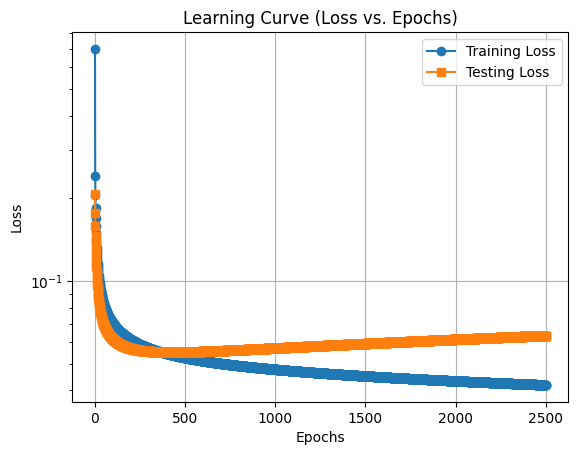

In [62]:
lrgd_reg.plot_learning_curve()

**Confidence of predictions vs Accuracy**

In [63]:
# Predict probabilities for the training set
probabilities_training = lrgd_reg.predict_proba(X_train_scaled)

# Predict probabilities for the test set
probabilities_test = lrgd_reg.predict_proba(X_test_scaled)

pred_test = lrgd_reg.predict(X_test_scaled)


In [64]:
# average probabilities for positive predictions

ave_prob_train = np.mean(probabilities_training[y_train==1])
ave_prob_test  = np.mean(probabilities_test[y_test==1])

print(f"average prob. (train==1): {ave_prob_train:.4f}, average prob. (test==1): {ave_prob_test:.4f}")

average prob. (train==1): 0.9656, average prob. (test==1): 0.9592


### ROC curve

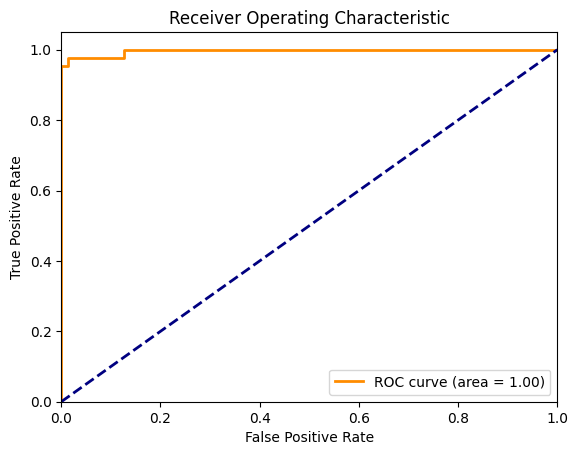

In [65]:
#TPR = TP / (TP+FN)
#FPR = FP / (FP+TN)

from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
probabilities_test = lrgd_reg.predict_proba(X_test_scaled)

#print(f"probabilities:\n {probabilities_test}\n\n")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test,pos_label=1)
roc_auc = auc(fpr, tpr)


# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [66]:
y_pred_test = lrgd_reg.predict(X_test_scaled)

count_corr_pos = np.sum(y_pred_test[y_test==1]==1)

count_corr_neg = np.sum(y_pred_test[y_test==0]==0)

total_accuracy = (count_corr_pos+count_corr_neg)/(len(y_test))

print(f"recall: {count_corr_pos/len(y_test[y_test==1]):.4}")
print(f"neg. accuracy: {count_corr_neg/len(y_test[y_test==0]):.4}")
print(f"tot. accuracy: {total_accuracy:.4}")

recall: 0.9767
neg. accuracy: 0.9859
tot. accuracy: 0.9825


### K-Fold cross-validation

A possible recipe:

* In most workflows, you first split the data into a training set (X_train, y_train) and a test set (X_test, y_test) to evaluate how the model generalizes to unseen data.

* Cross-validation, such as StratifiedKFold ( *'stratified' ensure that the distribution of certain characteristics, e.g., class labels, in the subsets is representative of the overall dataset* ), is then applied only on the training data to fine-tune model hyperparameters, estimate performance, or perform model selection without looking at the test data.

* The test set is reserved for final evaluation after cross-validation, ensuring that your model doesn't overfit the validation process.


In [67]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

# Initialize a list to store accuracy scores
scores = []

# Perform Stratified K-Fold cross-validation
for k, (train_idx, test_idx) in enumerate(kfold.split(X_train_scaled, y_train)):
    # Train the model on the training fold
    lrgd_reg.fit(X_train_scaled[train_idx], y_train[train_idx], X_train_scaled[test_idx], y_train[test_idx])

    # Evaluate the model on the test fold
    score = lrgd_reg.score(X_train_scaled[test_idx], y_train[test_idx])
    scores.append(score)

    # Print fold results
    print(f'Fold: {k+1:02d}, '
          f'Class distribution: {np.bincount(y_train[train_idx])}, '
          f'Accuracy: {score:.3f}')

# Calculate mean and standard deviation of accuracy
mean_acc = np.mean(scores)
std_acc = np.std(scores)

# Print cross-validation results
print(f'\nCross-Validation Accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


Fold: 01, Class distribution: [257 152], Accuracy: 0.978
Fold: 02, Class distribution: [257 152], Accuracy: 0.978
Fold: 03, Class distribution: [257 152], Accuracy: 0.978
Fold: 04, Class distribution: [257 152], Accuracy: 0.957
Fold: 05, Class distribution: [257 152], Accuracy: 1.000
Fold: 06, Class distribution: [257 153], Accuracy: 1.000
Fold: 07, Class distribution: [258 152], Accuracy: 0.978
Fold: 08, Class distribution: [258 152], Accuracy: 0.978
Fold: 09, Class distribution: [258 152], Accuracy: 0.933
Fold: 10, Class distribution: [258 152], Accuracy: 0.933

Cross-Validation Accuracy: 0.971 +/- 0.022


### Tuning the Hyperparameters

In [69]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.8 MB/s eta 0:00:00


In [75]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize
from skopt.space import Real

# Define your custom logistic regression model class as per previous code
# LogisticRegressionGD_L1reg class is assumed to be defined already

# Define the search space for alpha (regularization) and eta (learning rate)
search_space = [
    Real(1e-5, 1e1, prior='log-uniform'),  # L1 regularization term (alpha)
    Real(1e-5, 1e0, prior='log-uniform')   # Learning rate (eta)
]

# Objective function to minimize: We want to minimize the negative average accuracy
def objective(params):
    alpha, eta = params

    # Initialize your model with the parameters to optimize
    model = LogisticRegressionGD_L1reg(alpha=alpha, eta=eta, n_iter=100)

    # Stratified K-Fold Cross-validation setup
    kfold = StratifiedKFold(n_splits=10)
    scores = []

    # Perform cross-validation
    for train_idx, test_idx in kfold.split(X_train_scaled, y_train):
        model.fit(X_train_scaled[train_idx], y_train[train_idx], X_train_scaled[test_idx], y_train[test_idx])
        score = model.score(X_train_scaled[test_idx], y_train[test_idx])
        scores.append(score)

    # Return the negative mean accuracy (since we want to minimize)
    return -np.mean(scores)

# Run Bayesian optimization using GPMinimize
result = gp_minimize(objective, search_space, n_calls=30, random_state=0)

# Output results of the optimization
print("Best score achieved: %.4f" % (-result.fun))  # result.fun is the minimized negative accuracy
print("Best parameters found:")
print("alpha: %.4f" % result.x[0])
print("eta: %.6f" % result.x[1])


Best score achieved: 0.9802
Best parameters found:
alpha: 0.0001
eta: 0.224097


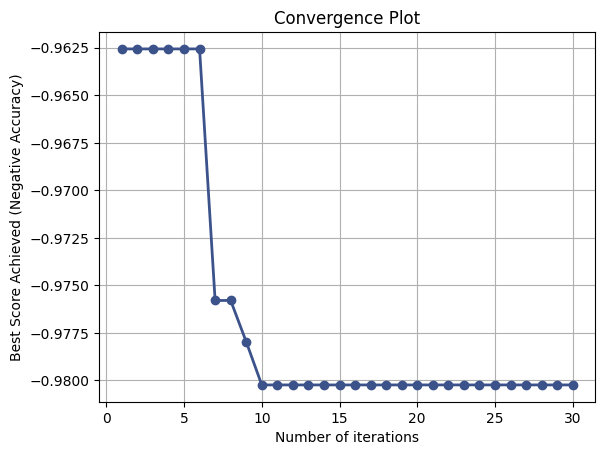

In [76]:
from skopt.plots import plot_convergence

# Plot convergence plot
plot_convergence(result)
plt.title('Convergence Plot')
plt.xlabel('Number of iterations')
plt.ylabel('Best Score Achieved (Negative Accuracy)')
plt.grid(True)
plt.show()

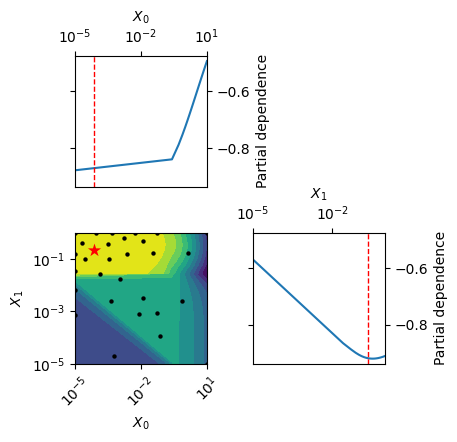

In [85]:
from skopt.plots import plot_objective

# Plot 2D contour plot of the surrogate model
fig = plot_objective(result)

plt.show()